In [1]:
FOLDER_PATH = "/content/drive/MyDrive/kaiga"

In [2]:
import os.path as osp
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil
import torchvision.transforms as transforms
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch

In [3]:
train_df = pd.read_csv(osp.join(FOLDER_PATH, "train.csv"))
train_df.head()

,image,gender_status
0,n_00001.jpg,4
1,n_00002.jpg,0
2,n_00003.jpg,0
3,n_00005.jpg,0
4,n_00006.jpg,0


In [4]:
vc = train_df["gender_status"].value_counts()
print(vc)

gender_status
1    1294
0    1210
4     834
2     375
3     371
7     100
6      53
5       1
Name: count, dtype: int64


In [5]:

#shutil.unpack_archive(osp.join(FOLDER_PATH, 'train.zip'), FOLDER_PATH)
#shutil.unpack_archive(osp.join(FOLDER_PATH, 'test.zip'), FOLDER_PATH)

In [6]:
# 性別で分ける
train_df['gender'] = 1
for i in range(len(train_df)):
  if train_df.at[i, 'gender_status'] < 4:
    train_df.at[i, 'gender'] = 0
train_df.head(10)

,image,gender_status,gender
0,n_00001.jpg,4,1
1,n_00002.jpg,0,0
2,n_00003.jpg,0,0
3,n_00005.jpg,0,0
4,n_00006.jpg,0,0
5,n_00007.jpg,3,0
6,n_00008.jpg,1,0
7,n_00010.jpg,2,0
8,n_00011.jpg,0,0
9,n_00012.jpg,0,0


In [7]:
import os

In [8]:
def split_dir(src_dir, tar_dir, df):
  if not osp.exists(tar_dir):
    os.makedirs(tar_dir)
  for file_name in df['image']:
    src_path = osp.join(src_dir, file_name)
    tar_path = osp.join(tar_dir, file_name)
    shutil.copy(src_path, tar_path)

In [9]:
#split_dir(osp.join(FOLDER_PATH, 'train'), osp.join(FOLDER_PATH, 'train_male'), df_male)
#split_dir(osp.join(FOLDER_PATH, 'train'), osp.join(FOLDER_PATH, 'train_female'), df_female)

In [10]:
#身分で分ける
train_df['status'] = 1
for i in range(len(train_df)):
  train_df.at[i, 'status'] = train_df.at[i, 'gender_status'] % 4
train_df.head(10)

,image,gender_status,gender,status
0,n_00001.jpg,4,1,0
1,n_00002.jpg,0,0,0
2,n_00003.jpg,0,0,0
3,n_00005.jpg,0,0,0
4,n_00006.jpg,0,0,0
5,n_00007.jpg,3,0,3
6,n_00008.jpg,1,0,1
7,n_00010.jpg,2,0,2
8,n_00011.jpg,0,0,0
9,n_00012.jpg,0,0,0


In [11]:
df_noble = train_df[train_df['status'] == 0]
df_bushi = train_df[train_df['status'] == 1]
df_monster = train_df[train_df['status'] == 2]
df_common = train_df[train_df['status'] == 3]

In [12]:
train_x, val_x, train_y, val_y = train_test_split(train_df['image'], train_df['gender'], shuffle=True, test_size=0.25, stratify=train_df['gender'])
print(len(train_x))
print(len(val_x))
print(len(train_y))
print(len(val_y))

3178
1060
3178
1060


In [13]:
print(train_y.value_counts())
print(val_y.value_counts())

gender
0    2437
1     741
Name: count, dtype: int64
gender
0    813
1    247
Name: count, dtype: int64


In [14]:
print(train_x)

2965    n_03672.jpg
2554    n_03162.jpg
2480    n_03070.jpg
3085    n_03830.jpg
1027    n_01275.jpg
           ...     
835     n_01030.jpg
1661    n_02059.jpg
2496    n_03091.jpg
922     n_01138.jpg
1012    n_01257.jpg
Name: image, Length: 3178, dtype: object


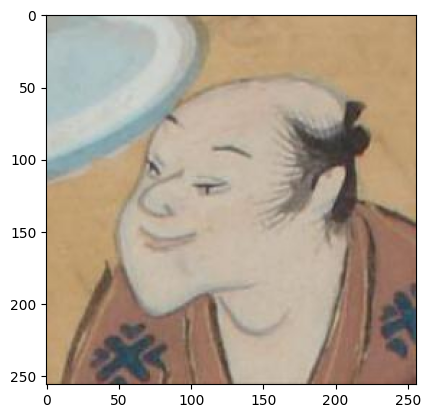

In [15]:
img = Image.open(osp.join(FOLDER_PATH, 'train', train_x.iloc[0]))
plt.imshow(img)
plt.show()

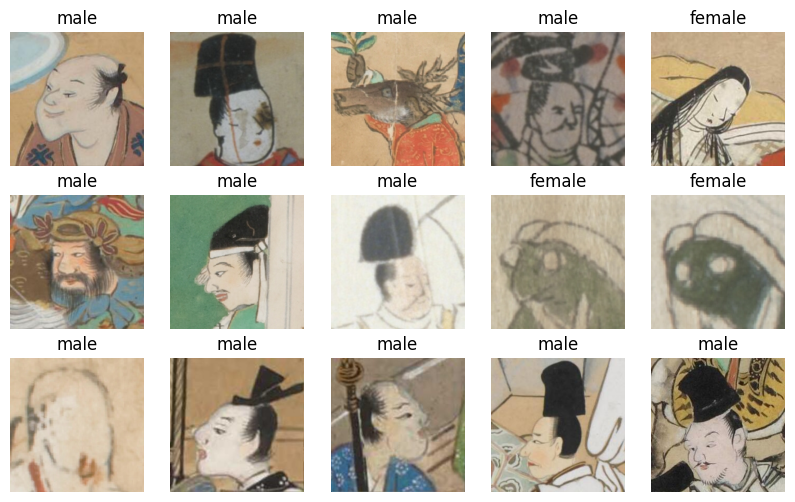

In [16]:
fig, axes = plt.subplots(3, 5, figsize=(10, 6))  # 2行3列のグリッドを設定
for i in range(len(axes.ravel())):
    ax = axes.ravel()[i]
    img = Image.open(osp.join(FOLDER_PATH, 'train', train_x.iloc[i]))
    ax.set_title('male' if train_y.iloc[i] == 0 else 'female')
    ax.imshow(img)
    ax.axis('off')

In [17]:
class ImageTransform():
  def __init__(self, resize, mean, std):
    self.data_transform = {
      'train': transforms.Compose([
        transforms.RandomCrop((224,224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=30),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
      ]),
      'val': transforms.Compose([
        transforms.Resize(resize),
        transforms.CenterCrop(resize),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
      ])
    }
  def __call__(self, img, phase='train'):
    return self.data_transform[phase](img)

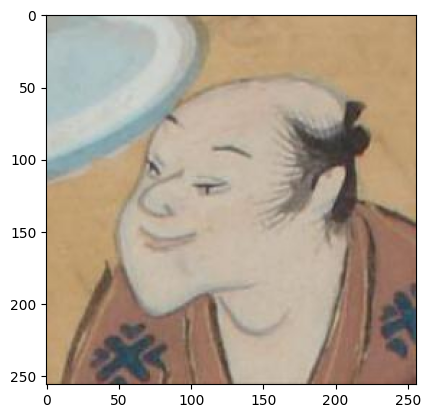

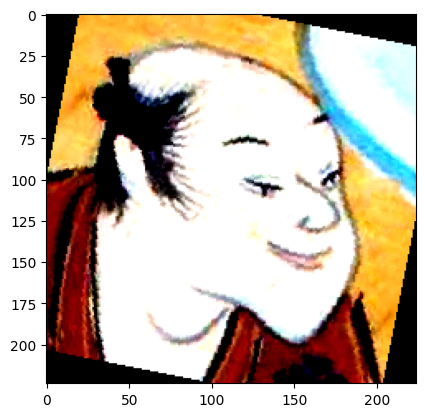

In [18]:
img = Image.open(osp.join(FOLDER_PATH, 'train', train_x.iloc[0]))

# 元画像の表示
plt.imshow(img)
plt.show()

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase = 'train')

# 変換後の画像の表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [19]:
class GenderDataset(Dataset):
  def __init__(self, file_df, label_df, transform=None, phase='train'):
    self.file_df = file_df
    self.label_df = label_df
    self.transform = transform
    self.phase = phase

  def __len__(self):
    return len(self.file_df)

  def __getitem__(self, index):
    img_name = self.file_df.iloc[index]
    img = Image.open(osp.join(FOLDER_PATH, 'train', img_name))

    img_transformed = self.transform(img, self.phase)
    label = self.label_df.iloc[index]
    return img_transformed, label

In [20]:
train_dataset = GenderDataset(train_x, train_y, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = GenderDataset(val_x, val_y, transform=ImageTransform(size, mean, std), phase='val')


index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [21]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {'train': train_loader, 'val': val_loader}
batch_iterator = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0])


In [22]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)
print(net)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 103MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
net.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [24]:
params_to_update = []
update_params_name = ['classifier.6.weight', 'classifier.6.bias']
for name, param in net.named_parameters():
  if name in update_params_name:
    param.requires_grad = True
    params_to_update.append(param)
    print(name)
  else:
    param.requires_grad = False

print("-----------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
-----------
[Parameter containing:
tensor([[ 9.4191e-03,  2.9719e-03, -5.2198e-03,  ..., -1.1316e-02,
          1.4013e-02, -4.0175e-03],
        [-9.2201e-07,  3.7366e-03,  3.4694e-03,  ...,  5.0441e-03,
         -1.2123e-02,  1.2743e-02]], requires_grad=True), Parameter containing:
tensor([-0.0151, -0.0113], requires_grad=True)]


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [26]:
def train_model(net, dataloaders_dict, criterion, num_epochs):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("device:", device)
  net.to(device)

  optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
  torch.backends.cudnn.benchmark = True

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))

    print("----------------")

    for phase in ['train', 'val']:
      if phase == 'train':
        net.train()
      else:
        net.eval()

      epoch_loss = 0.0
      epoch_corrects = 0

      if (epoch == 0) and (phase == 'train'):
        continue

      # データローダーからミニバッチを取り出す
      for inputs, labels in tqdm(dataloaders_dict[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # オプティマイザを初期化
        optimizer.zero_grad()

        # 順伝搬計算
        with torch.set_grad_enabled(phase == 'train'):
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs, 1)

          if phase == 'train':
            loss.backward()
            optimizer.step()

          epoch_loss += loss.item() * inputs.size(0)
          epoch_corrects += torch.sum(preds == labels.data)

      epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
      epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [27]:
num_epochs = 2
train_model(net, dataloaders_dict, criterion, num_epochs=num_epochs)

device: cpu
Epoch 1/2
----------------


100%|██████████| 34/34 [15:02<00:00, 26.55s/it]


val Loss: 0.6582 Acc: 0.6283
Epoch 2/2
----------------


100%|██████████| 100/100 [46:26<00:00, 27.86s/it]


train Loss: 0.4130 Acc: 0.8203


100%|██████████| 34/34 [11:55<00:00, 21.06s/it]

val Loss: 0.2947 Acc: 0.8896
